In [2]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Units

In [3]:
MHz = 2 * jnp.pi
kHz = 1e-3 * MHz
us = 1
ns = 1e-3 * us

# Thermal state

In [4]:
def thermal_dm(N, n):
    if n == 0:
        return dq.fock_dm(N, 0)
    i = jnp.arange(N)
    dm = jnp.diag((1.0 + n) ** (-1.0) * (n / (1.0 + n)) ** (i))
    return dq.unit(dm)

# Simulate function

In [5]:
def simulate_deflate(Na, Nb, g2, kappa_a, kappa_b, nth, times, alphas):
    a, b = dq.destroy(Na, Nb)

    rho_mem = thermal_dm(Na, nth)
    displ = dq.displace(Na, alphas)
    rho_mem = dq.unit(displ @ rho_mem @ dq.dag(displ))
    rho_0 = dq.tensor(rho_mem, dq.fock_dm(Nb, 0))

    H = g2 * dq.dag(a) @ dq.dag(a) @ b
    H += dq.dag(H)

    Lb = jnp.sqrt(kappa_b) * b
    Ladn = jnp.sqrt(kappa_a * (1 + nth)) * a
    Laup = jnp.sqrt(kappa_a * nth) * dq.dag(a)
    c_ops = [Lb, Ladn, Laup]

    output = dq.mesolve(H, c_ops, rho_0, times, exp_ops=[dq.dag(a) @ a])
    return output.expects[:, 0]

In [6]:
g2 = 1.2 * MHz
kappa_a = 10 * kHz
kappa_b = 15 * MHz
kappa_2 = 4 * g2**2 / kappa_b
n_th = 1.0

tsaves = jnp.geomspace(10 * ns, 10 * us, 1001)[1:]
alphas = jnp.linspace(0, 2, 11)
adaga = simulate_deflate(20, 5, g2, kappa_a, kappa_b, n_th, tsaves, alphas)

2024-10-03 13:37:58.746876: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
|██████████| 100.0% ◆ total 1.79s ◆ remaining 00:00


/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


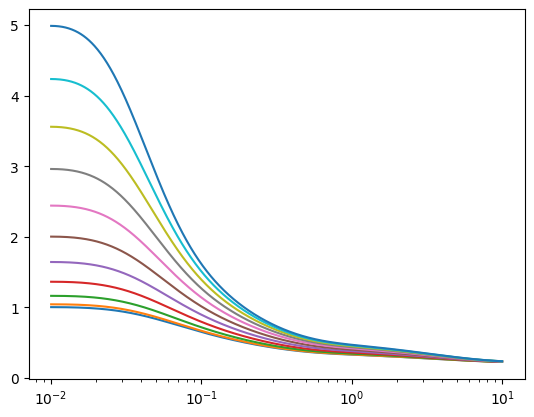

In [7]:
plt.plot(tsaves, adaga.T)
plt.xscale("log")

# Loading exp data

In [8]:
data_exp = np.load("fit_deflate.npy", allow_pickle=True).item()

In [9]:
signal_exp = data_exp["signal"]
durations = data_exp["durations_ns"] * ns
alpha_disp = data_exp["alpha_disps"]
nconv_guess = data_exp["nconv"]

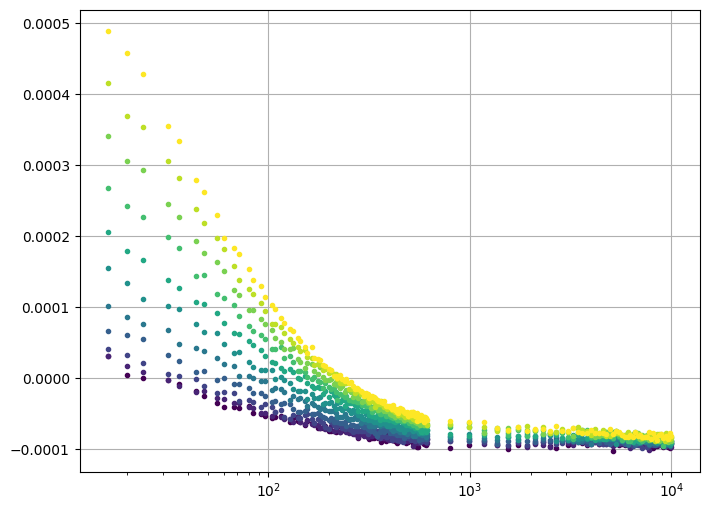

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(alpha_disp)))
for ind, c in enumerate(colors):
    ax.plot(
        durations / ns,
        signal_exp[ind],
        ".",
        color=c,
        label=f"$\\alpha={alpha_disp[ind]}$",
    )
ax.set_xscale("log")
ax.grid(True)

# Fitting data

In [11]:
Na, Nb, times, alphas, kappa_b = 20, 5, durations, alphas, 18 * MHz


def simulate_deflate(_, kappa_2, kappa_a, nth, t0, A, B):
    a, b = dq.destroy(Na, Nb)

    rho_mem = thermal_dm(Na, nth)
    displ = dq.displace(Na, alphas)
    rho_mem = dq.unit(displ @ rho_mem @ dq.dag(displ))
    rho_0 = dq.tensor(rho_mem, dq.fock_dm(Nb, 0))

    g2 = 0.5 * jnp.sqrt(kappa_2 * kappa_b)
    H = g2 * dq.dag(a) @ dq.dag(a) @ b
    H += dq.dag(H)

    Lb = jnp.sqrt(kappa_b) * b
    Ladn = jnp.sqrt(kappa_a * (1 + nth)) * a
    Laup = jnp.sqrt(kappa_a * nth) * dq.dag(a)
    c_ops = [Lb, Ladn, Laup]

    # tsave = np.concatenate(([0], durations+t0))
    tsave = durations + t0
    # print(durations+t0)
    output = dq.mesolve(
        H, c_ops, rho_0, tsave=tsave, exp_ops=[dq.dag(a) @ a], options=dq.Options(t0=0)
    )
    return output.expects[:, 0].real.flatten() * A + B

In [12]:
kappa_2 = 0.3 * MHz
kappa_a = 10 * kHz
n_th = 0.93
t0 = 10 * ns
A = 1.2e-4
B = -1.2e-4

guess = (kappa_2, kappa_a, n_th, t0, A, B)
tss, alss = jnp.meshgrid(durations, alphas)
signal_simu = simulate_deflate(_, *guess).reshape(signal_exp.shape)

|██████████| 100.0% ◆ total 1.95s ◆ remaining 00:00


/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


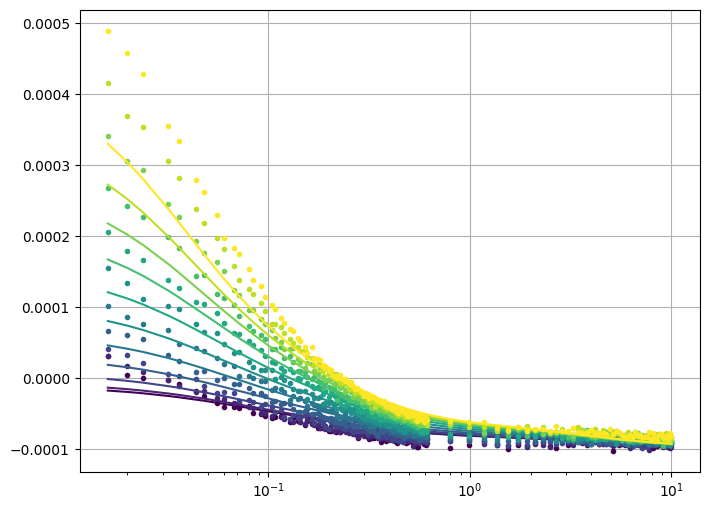

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(alpha_disp)))
for ind, c in enumerate(colors):
    ax.plot(durations / us, signal_exp[ind], ".", color=c)
    ax.plot(durations / us, signal_simu[ind], color=c)
ax.set_xscale("log")
ax.grid(True)

In [44]:
popt, pcov = curve_fit(
    simulate_deflate,
    (tss.flatten(), alss.flatten()),
    signal_exp.flatten(),
    p0=guess,
    bounds=((0, 1 / (70 * us), 0, 0, -np.inf, -np.inf), np.inf),
)

/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
|██████████| 100.0% ◆ total 1.76s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.69s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.69s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.69s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.68s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.68s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.69s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.85s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.79s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.79s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.79s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.79s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.79s ◆ remaining 00:00
|██████████| 100.0% ◆ total 2.02s ◆ remaining 00:00
|██████████| 100.0% ◆ total 1.97s ◆ remaining 00:00
|██

In [45]:
popt

array([ 2.29060471e+00,  1.25663706e-02,  9.37208846e-01,  2.85352499e-03,
        1.63439929e-04, -1.45291121e-04])

In [46]:
pcov

array([[ 5.28036171e-04,  5.98322186e-06, -8.32858099e-05,
         6.99040277e-06,  3.18966782e-08, -7.36565355e-09],
       [ 5.98322186e-06,  2.71512148e-07, -1.84854954e-06,
         7.04562733e-09,  1.76055682e-10,  5.21297163e-11],
       [-8.32858099e-05, -1.84854954e-06,  3.83382512e-05,
        -5.23219089e-07, -4.12916424e-09,  2.88468220e-10],
       [ 6.99040277e-06,  7.04562733e-09, -5.23219089e-07,
         2.30273771e-07,  7.24876200e-10, -2.54518674e-10],
       [ 3.18966782e-08,  1.76055682e-10, -4.12916424e-09,
         7.24876200e-10,  2.67887443e-12, -8.40786423e-13],
       [-7.36565355e-09,  5.21297163e-11,  2.88468220e-10,
        -2.54518674e-10, -8.40786423e-13,  3.35422060e-13]])

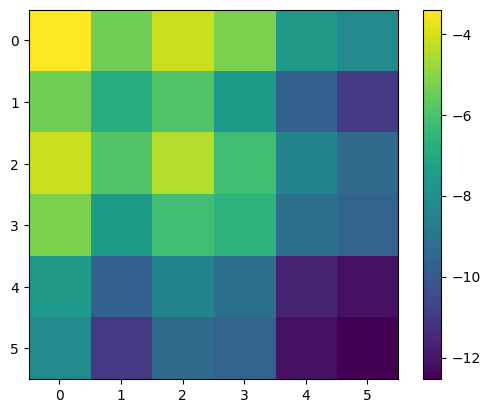

In [17]:
plt.imshow(np.log10(np.abs(pcov)))
plt.colorbar()

In [34]:
signal_fit = simulate_deflate((tss.flatten(), alss.flatten()), *popt).reshape(
    signal_exp.shape
)

|          |   0.0% ◆ total 0.00s ◆ remaining ?

|██████████| 100.0% ◆ total 1.81s ◆ remaining 00:00


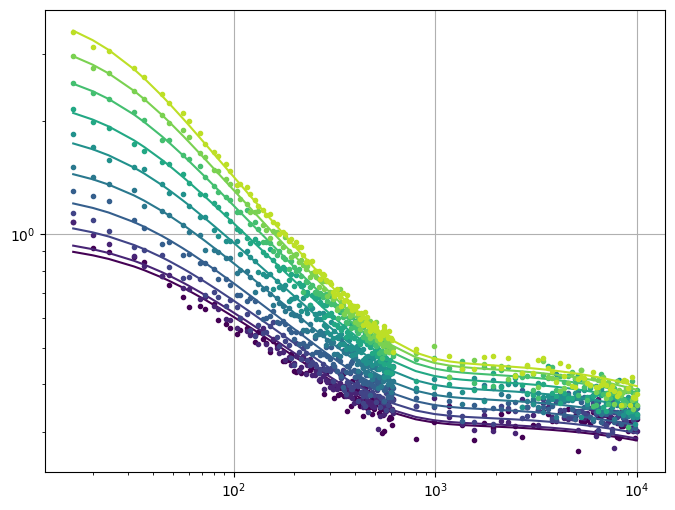

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(alpha_disp)))
for ind, c in enumerate(colors[:10]):
    ax.plot(durations / ns, (signal_exp[ind] - popt[-1]) / popt[-2], ".", color=c)
    ax.plot(durations / ns, (signal_fit[ind] - popt[-1]) / popt[-2], color=c)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True)

In [49]:
np.save("deflate_fit.npy", {"fit": signal_fit, "popt": popt, "pcov": pcov})

In [ ]:
np.l